# LSTM_Stock_Prediction


給定 2010 ~ 2016 紐約股市的資料：

1. `stt.csv`：State Street Corp (STT) 的資料。
2. `all.csv`：STT 以外其他公司的資料。

csv 中每一行有以下欄位：

1. `date`：日期
2. `symbol`: 公司
3. `open`：開盤價
4. `close`：收盤價
5. `low`：低點
6. `hight`：高點
7. `volume`：交易量

作業如下：

1. 使用 STT 前 15 天的資料來預測第 16 天的交易量(50%)
2. 使用所有跟 STT 同領域的公司前 15 天的資料來預測 STT 第 16 天的收盤價(50%)



### 以下範例程式使用STT過去15天的`open`、`close`、`low`和`volume`（without  `high`），來預測STT第16天的最高價（`high`）。

## Task:

1. Use a RNN/LSTM.
2. Plot the loss curve.
3. Report the $MSE$ between your predictions and groundtruths. (both train and valid set)

$$
MSE = \frac{1}{N} \sum_1^N (p_i - q_i)^2
$$
4. Plot the prediction vs groundtruth. (both train and valid set)


where $N$ is number of days and $p_i, q_i$ are the prediction and groudtruth on day $i$ respectively.


## Download Data and Import Libraries

In [86]:
from pathlib import Path
from torchvision.datasets.utils import download_file_from_google_drive

csv_path_stt = Path('./stt.csv')
csv_path_all = Path('./all.csv')

if not csv_path_stt.exists():
    download_file_from_google_drive('1zY26f3Ie5c7Vt9R0wHRz9hGldOsizV4b', '.', csv_path_stt)
if not csv_path_all.exists():
    download_file_from_google_drive('1KtyafQZRtx3FOWpFEe-keoeiVTb2y7Fu', '.', csv_path_all)

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, Sampler

from sklearn.preprocessing import StandardScaler

In [88]:
df_stt = pd.read_csv(csv_path_stt).sort_values(by='date')      # csv are not guarenteed to be ordered by date
df_stt_target = df_stt[['close']].reset_index(drop=True)

print(f"df_stt shape: {df_stt_target.shape}")
df_stt_target.head(10)

df_stt shape: (1762, 1)


,close
0,44.459999
1,44.549999
2,43.810001
3,44.599998
4,45.509998
5,44.360001
6,44.200001
7,44.610001
8,43.790001
9,42.669998


In [ ]:
df_all = pd.read_csv(csv_path_all)  # read all data of stock market
df_ual = df_all[df_all['symbol'] == 'UAL']              # select entries that has symbol 'UAL'
df_ual = df_ual.sort_values(by='date')                 # sort by date
df_ual_features = df_ual[['date', 'open', 'low', 'high', 'volume']].reset_index(drop=True)

print(f'df_ual shape: {df_ual_features.shape}')  # (1762, 5)
df_ual_features.head(10)                               # show the first 10 rows

df_ual shape: (1762, 5)


,date,open,low,high,volume
0,2010-01-04,12.99,12.53,13.11,8785900.0
1,2010-01-05,12.87,12.87,14.10,23646300.0
2,2010-01-06,13.74,13.13,13.99,15398700.0
3,2010-01-07,13.20,13.20,13.95,10177000.0
4,2010-01-08,13.56,13.13,13.86,5896400.0
5,2010-01-11,13.36,12.66,13.42,10168600.0
6,2010-01-12,13.00,12.59,13.16,7203300.0
7,2010-01-13,12.75,12.53,14.05,25097400.0
8,2010-01-14,13.84,13.65,14.11,8794300.0
9,2010-01-15,13.93,13.22,14.07,10210700.0


In [90]:
# combine the two DataFrames 
df_ual_stt = pd.concat([df_ual_features, df_stt_target], axis=1)  # axis=1 means column-wise
df_ual_stt.head(1800)  # show the first 10 rows

,date,open,low,high,volume,close
0,2010-01-04,12.990000,12.530000,13.110000,8785900.0,44.459999
1,2010-01-05,12.870000,12.870000,14.100000,23646300.0,44.549999
2,2010-01-06,13.740000,13.130000,13.990000,15398700.0,43.810001
3,2010-01-07,13.200000,13.200000,13.950000,10177000.0,44.599998
4,2010-01-08,13.560000,13.130000,13.860000,5896400.0,45.509998
...,...,...,...,...,...,...
1757,2016-12-23,74.400002,74.129997,74.830002,1616800.0,78.690002
1758,2016-12-27,74.779999,74.500000,75.220001,1092400.0,79.000000
1759,2016-12-28,75.000000,73.349998,75.180000,1935400.0,78.400002
1760,2016-12-29,73.529999,72.930000,74.190002,1272400.0,77.660004


### Train/Valid Split and Feature Normalization

We split first 85% of the entries to be training data, and last 15% to be validation data.
The pivot date is 2015-12-15, i.e., entries after 2015-12-15 (included) is valid data.


Note that scale of the features (`open`, `close`, `low`, `high`, `volume`) are different to each other. In practice, we normalize each features to better train our model. If we do so, the model will suffer gradient vanishment/exploding.

To normalize data, common techniques are:

1. Standard Scaler: $x_{new} = (x - mean) / std$
2. Minmax Scaler: $x_{new} = (x - x_{min}) / (x_{max} - x_{min})$

Both are implemented in `sklearn`. In this code, we use the first one.

**Be careful that when normalizing data, we can use only training data to compute the statistics. Using validation/testing data is not allowed.**


In some cases, we need to obtain original values from normalized features, we can do it using the standard scaler `std` used for normalization.

```python
raw_open = normalize_open* std.scale_[0] + std.mean_[0]
raw_close = normalized_close * std.scale_[1] + std.mean_[1]
raw_low = normalized_low * std.scale_[2] + std.mean_[2]
raw_high = normalized_low * std.scale_[3] + std.mean_[3]
raw_volume = normalized_low * std.scale_[4] + std.mean_[4]
```

In [91]:
# split the data into training and validation sets
pivot = round(0.85 * len(df_ual_stt))
print('pivot:', df_ual_stt.loc[pivot, 'date'])
df_train = df_ual_stt[:pivot].copy()    # DataFrame
df_valid = df_ual_stt[pivot:].copy()    # DataFrame

FEATURES = ['open', 'close', 'low', 'high', 'volume']
std = StandardScaler().fit(df_train[FEATURES])
df_train[FEATURES] = std.transform(df_train[FEATURES])
df_valid[FEATURES] = std.transform(df_valid[FEATURES])

df_train.head(10)


pivot: 2015-12-15


,date,open,low,high,volume,close
0,2010-01-04,-1.339408,-1.350487,-1.353651,0.707887,-0.767338
1,2010-01-05,-1.347168,-1.328160,-1.290444,4.692716,-0.761233
2,2010-01-06,-1.290906,-1.311086,-1.297467,2.481115,-0.811429
3,2010-01-07,-1.325828,-1.306489,-1.300021,1.080911,-0.757841
4,2010-01-08,-1.302547,-1.311086,-1.305767,-0.066935,-0.696113
5,2010-01-11,-1.315481,-1.341950,-1.333859,1.078659,-0.774121
6,2010-01-12,-1.338761,-1.346547,-1.350458,0.283511,-0.784974
7,2010-01-13,-1.354929,-1.350487,-1.293636,5.081830,-0.757163
8,2010-01-14,-1.284439,-1.276938,-1.289806,0.710139,-0.812786
9,2010-01-15,-1.278619,-1.305175,-1.292359,1.089948,-0.888759


# Dataset

To predict the stock on day 16 based on day 1 ~ day 15 features, we expect each sample contains:

1. `feature`: the features of day 1 ~ 15. Each day has 4 features, thus the shape is `[15, 4]`.
2. `target`: the target we are predicting. In this case, it's the `high` of day 16, thus `target` is a shaped `[1]`.

Therefore we are performing a *sliding window*-like operation on the given dataframe.

In [92]:
class CompanyStockData(Dataset):
    def __init__(self, dataframe, window=10):
        super().__init__()
        self.df = dataframe
        self.window = window

    def __len__(self):
        return len(self.df) - self.window

    def __getitem__(self, idx):
        window_s = idx
        window_t = idx + self.window
        feature = self.df.iloc[window_s:window_t - 1]                            # Retrieve entries [window_s, window_t - 1], DataFrame
        # feature = feature[['open', 'close', 'low', 'volume']].values                    # Retrieve the wanted features. `.values` make it ndarray
        feature = feature[['open', 'low', 'high', 'volume']].values
        feature = torch.from_numpy(feature).float()                               # Converty ndarray to tensor
        target = self.df.iloc[window_t - 1]                                 # The entry on the next day
        # target = target['high'].item()                                      # Make it python scalar
        target = target['close'].item()
        target = torch.tensor([target]).float()                               # Make it tensor
        return feature, target


WINDOW = 16
train_set = CompanyStockData(df_train, window=WINDOW)
valid_set = CompanyStockData(df_valid, window=WINDOW)
print('#train:', len(train_set))
print('#valid:', len(valid_set))

feature, target = valid_set[100]
print(feature)
print(target)

#train: 1482
#valid: 248
tensor([[ 0.7998,  0.8337,  0.8177, -0.3618],
        [ 0.8425,  0.8337,  0.8356, -0.2887],
        [ 0.7973,  0.6721,  0.7481,  0.4736],
        [ 0.6466,  0.6912,  0.6785, -0.1018],
        [ 0.6867,  0.6839,  0.6741, -0.0179],
        [ 0.6886,  0.7371,  0.7513, -0.0612],
        [ 0.7248,  0.7706,  0.7641, -0.4466],
        [ 0.7132,  0.6931,  0.7009, -0.1528],
        [ 0.6912,  0.7306,  0.7009, -0.7681],
        [ 0.7009,  0.7260,  0.6824, -0.6437],
        [ 0.6957,  0.7417,  0.6875, -0.6550],
        [ 0.7384,  0.7864,  0.7424, -0.6692],
        [ 0.7436,  0.7253,  0.7034, -0.3365],
        [ 0.7022,  0.7509,  0.7117, -0.6775],
        [ 0.7391,  0.7358,  0.7015, -0.0175]])
tensor([0.4876])


# Model

We implements following model:



In [93]:
class LSTM(nn.Module):
    def __init__(self, input_size=4, hidden_size=32, num_layers=1, num_classes=1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True
        )
        self.regressor = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x, (h, c) = self.lstm(x)
        x = self.regressor(x[:, -1])        # We only takes last timestamps output of lstm
        return x

train_loader = DataLoader(
    train_set,
    shuffle=True,
    batch_size=8,
    num_workers=4,
)
valid_loader = DataLoader(
    valid_set,
    shuffle=False,
    batch_size=8,
    num_workers=4,
)

feature_b, target_b = next(iter(valid_loader))
print(feature_b.shape)  # [N, 15, 4]
print(target_b.shape)   # [N, 1]

model = LSTM(input_size=4, hidden_size=32, num_classes=1)
output_b = model(feature_b)
print(output_b.shape)   # [N, 1]

torch.Size([8, 15, 4])
torch.Size([8, 1])
torch.Size([8, 1])


Some other RNN model you can try:

In [94]:
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BiLSTM, self).__init__()

        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers, batch_first=True, bidirectional=True
        )
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.fc(x[:, -1, :])
        return x


class GRU(nn.Module):
    def __init__(self, input_size, hidden_size=1, num_layers=1, num_classes=1):
        super().__init__()

        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x, _ = self.gru(x)
        x = self.fc(x[:, -1, :])
        return x

# Training

Train the model in standard way and record losses every epoch.

In [95]:
device = 'cuda'
model = LSTM(input_size=4, hidden_size=32, num_layers=1, num_classes=1).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

history = {
    'train_loss': [],
    'valid_loss': [],
}

for epoch in range(50):
    # Train
    losses = []
    model.train()
    for feature_b, target_b in iter(train_loader):
        feature_b = feature_b.to(device)
        target_b = target_b.to(device)

        optimizer.zero_grad()
        predict_b = model(feature_b)
        loss = criterion(predict_b, target_b)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
    train_loss = sum(losses) / len(losses)

    # Valid
    losses = []
    model.eval()
    for feature_b, target_b in iter(valid_loader):
        feature_b = feature_b.to(device)
        target_b = target_b.to(device)
        predict_b = model(feature_b)
        loss = criterion(predict_b, target_b)
        losses.append(loss.item())
    valid_loss = sum(losses) / len(losses)

    # Logging
    history['train_loss'].append(train_loss)
    history['valid_loss'].append(valid_loss)
    print('Epoch {:03d}: {:.6f}, {:.6f}'.format(
        epoch, train_loss, valid_loss
    ))

Epoch 000: 0.221756, 0.596598
Epoch 001: 0.090437, 0.627683
Epoch 002: 0.087314, 0.542276
Epoch 003: 0.084430, 0.502156
Epoch 004: 0.081676, 0.495743
Epoch 005: 0.079081, 0.522992
Epoch 006: 0.076846, 0.605057
Epoch 007: 0.075384, 0.538043
Epoch 008: 0.074138, 0.627400
Epoch 009: 0.071340, 0.494486
Epoch 010: 0.071058, 0.549582
Epoch 011: 0.070297, 0.575364
Epoch 012: 0.071765, 0.608880
Epoch 013: 0.070334, 0.597083
Epoch 014: 0.068875, 0.552556
Epoch 015: 0.068602, 0.524480
Epoch 016: 0.069173, 0.587225
Epoch 017: 0.064674, 0.537801
Epoch 018: 0.064476, 0.551929
Epoch 019: 0.063754, 0.537519
Epoch 020: 0.063952, 0.545066
Epoch 021: 0.067944, 0.505169
Epoch 022: 0.063417, 0.573156
Epoch 023: 0.063338, 0.559930
Epoch 024: 0.061529, 0.496535
Epoch 025: 0.059521, 0.565714
Epoch 026: 0.060850, 0.574179
Epoch 027: 0.060020, 0.473152
Epoch 028: 0.058196, 0.561116
Epoch 029: 0.061287, 0.463728
Epoch 030: 0.057609, 0.544164
Epoch 031: 0.054952, 0.532561
Epoch 032: 0.055524, 0.537240
Epoch 033:

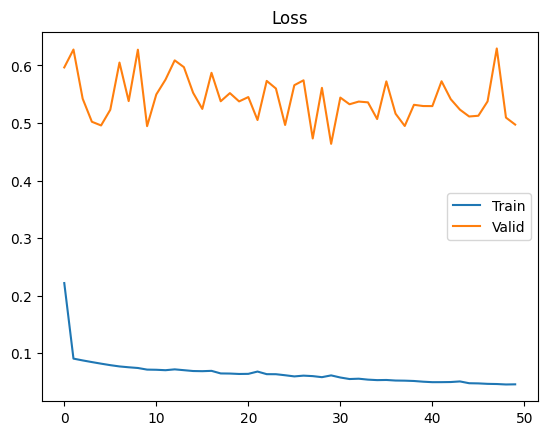

In [96]:
fig, ax = plt.subplots()
ax.plot(history['train_loss'], label='Train')
ax.plot(history['valid_loss'], label='Valid')
ax.set_title('Loss')
ax.legend()
plt.show()

## Evaluation



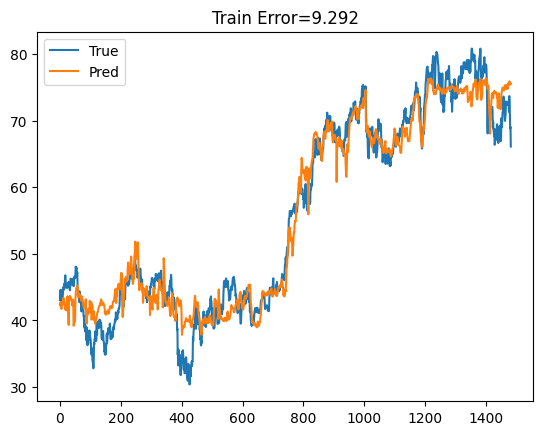

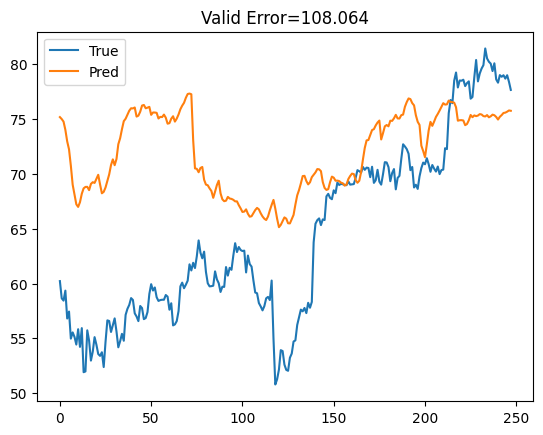

In [97]:
@torch.no_grad()
def evaluate(dataset):
    model.eval()
    preds = []
    trues = []
    loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)
    for feature_b, target_b in iter(loader):
        predict_b = model(feature_b.to(device)).to('cpu')
        preds.extend(predict_b)
        trues.extend(target_b)
    preds = torch.stack(preds).numpy() # [N]
    trues = torch.stack(trues).numpy() # [N]
    return preds, trues


preds, trues = evaluate(train_set)
# preds = preds * std.scale_[3] + std.mean_[3] # for high
# trues = trues * std.scale_[3] + std.mean_[3]
preds = preds * std.scale_[1] + std.mean_[1] # for close
trues = trues * std.scale_[1] + std.mean_[1]
error = ((preds - trues) ** 2).mean()
fig, ax = plt.subplots()
ax.plot(trues, label='True')
ax.plot(preds, label='Pred')
ax.set_title(f'Train Error={error:.3f}')
ax.legend()
plt.show()

preds, trues = evaluate(valid_set)
# preds = preds * std.scale_[3] + std.mean_[3] # for high
# trues = trues * std.scale_[3] + std.mean_[3]
preds = preds * std.scale_[1] + std.mean_[1] # for close
trues = trues * std.scale_[1] + std.mean_[1]
error = ((preds - trues) ** 2).mean()
fig, ax = plt.subplots()
ax.plot(trues, label='True')
ax.plot(preds, label='Pred')
ax.set_title(f'Valid Error={error:.3f}')
ax.legend()
plt.show()

## Useful DataFrame methods

1. Use `df.values` to get the underlying ndarray, and use `ndarray` operations.
2. **Use Excel, by hand or other tools you want to calculate the values.**



In [98]:
df_all = pd.read_csv(csv_path_all).sort_values('date')  # read all data of stock market

df_ual = df_all[df_all['symbol'] == 'UAL']              # select entries that has symbol 'UAL'
# df_ual = df_all[df_all['symbol'].isin(['UAL', 'WU'])] # another way, but can select multiple companies
df_ual = df_ual.reset_index(drop=True)                  # Reset the index to 0, 1, ..., 1761

print(df_ual)

df_ual = df_ual.drop(columns=['symbol', 'date'])        # drop symbol & date columns
data_ual = df_ual.values                                # get its underlying ndarray

print(data_ual.shape)
print(data_ual[:10])

            date symbol       open      close        low       high  \
0     2010-01-04    UAL  12.990000  12.800000  12.530000  13.110000   
1     2010-01-05    UAL  12.870000  13.910000  12.870000  14.100000   
2     2010-01-06    UAL  13.740000  13.270000  13.130000  13.990000   
3     2010-01-07    UAL  13.200000  13.550000  13.200000  13.950000   
4     2010-01-08    UAL  13.560000  13.330000  13.130000  13.860000   
...          ...    ...        ...        ...        ...        ...   
1757  2016-12-23    UAL  74.400002  74.790001  74.129997  74.830002   
1758  2016-12-27    UAL  74.779999  74.669998  74.500000  75.220001   
1759  2016-12-28    UAL  75.000000  73.529999  73.349998  75.180000   
1760  2016-12-29    UAL  73.529999  73.279999  72.930000  74.190002   
1761  2016-12-30    UAL  73.430000  72.879997  72.370003  73.430000   

          volume  
0      8785900.0  
1     23646300.0  
2     15398700.0  
3     10177000.0  
4      5896400.0  
...          ...  
1757   1616800

In [99]:
#df_all = pd.read_csv(csv_path_all).sort_values('date')  # read all data of stock market
#df_all = df_all.drop(columns=['date'])

#for symbol, group in df_all.groupby('symbol'):          # iterate different companies. group is a DataFrame that is subset of df_all
    #print('symbol:', symbol, 'shape:', group.shape)
    #print(group.sample(3))                              # print random 3 entries
    #group = group.drop(columns=['symbol'])              # drop symbol columns
    #print('mean:', group.mean(axis=0).values)           # compute mean of rest columns respectively
    #print('-' * 10)

In [100]:
df_all = pd.read_csv(csv_path_all).sort_values('date')  # read all data of stock market
df_all = df_all.drop(columns=['date'])

groups = [] # Select those companies that has 1762 entries and symbol is started with 'Y'
for symbol, group in df_all.groupby('symbol'):          # iterate different companies. group is a DataFrame that is subset of df_all
    if len(group) == 1762 and symbol.startswith('Y'):
        groups.append(group)
df = pd.concat(groups)                                  # Concatenate those groups
df = df.reset_index(drop=True)                          # Reset the index to 0, 1, ..., 1761

print(df.shape)
print(df['symbol'].unique())                            # Companies

(3524, 6)
['YHOO' 'YUM']
